In [1]:
# Import Modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#modeling tools
import statsmodels.api as sm

import lightgbm as lgb

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, auc, roc_auc_score, roc_curve, log_loss, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

%matplotlib inline
plt.style.use('dark_background')

%load_ext autoreload
%autoreload 2

pd.set_option('display.min_row', 15)
pd.set_option('display.max_column', 100)
pd.set_option('display.max_colwidth', 300)

In [2]:
collisions = pd.read_csv('../data/Collisions.csv')
clean_data = pd.read_pickle('../data/processed/cleaned_data.pkl')
intersection_n = pd.read_pickle('../data/processed/intersection_w_normalization.pkl')

crosswalks = pd.read_csv('../data/Marked_Crosswalks.csv')
circles = pd.read_csv('../data/Traffic_Circles.csv')
intersections = pd.read_csv('../data/Intersections.csv')

In [3]:
collisions['INJURED_OHE'] = collisions['INJURIES'].apply(lambda x: 1 if x > 0 else 0)

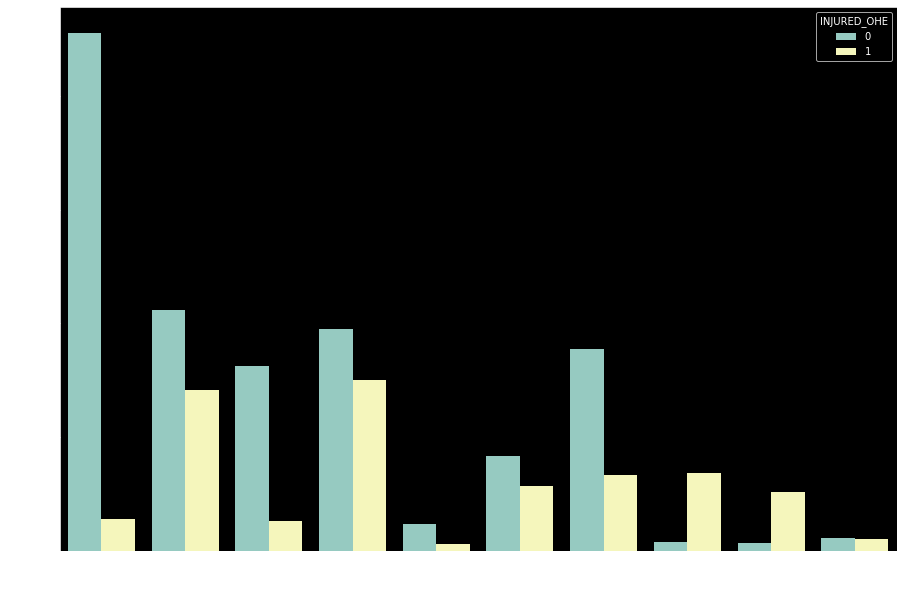

In [4]:
fig, ax = plt.subplots(figsize=(15,10))

ax = sns.countplot('COLLISIONTYPE', data=collisions, hue='INJURED_OHE');

In [5]:
print( 'Percent not injured: ', round((collisions['INJURED_OHE'] == 0).sum() / len(collisions['INJURED_OHE'])*100 , 3) )
print( 'Percent injured: ', round((collisions['INJURED_OHE'] != 0).sum() / len(collisions['INJURED_OHE'])*100 , 3) )

Percent not injured:  72.028
Percent injured:  27.972


## Traffic Circles

In [6]:
# no null values
circles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066 entries, 0 to 1065
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   X                          1066 non-null   float64
 1   Y                          1066 non-null   float64
 2   OBJECTID                   1066 non-null   int64  
 3   COMPKEY                    1066 non-null   int64  
 4   UNITID                     1066 non-null   object 
 5   UNITDESC                   1066 non-null   object 
 6   CONDITION                  1066 non-null   object 
 7   CONDITION_ASSESSMENT_DATE  1066 non-null   object 
 8   CURRENT_STATUS             1066 non-null   object 
 9   OWNERSHIP                  1066 non-null   object 
 10  PRIMARYDISTRICTCD          1066 non-null   object 
 11  SECONDARYDISTRICTCD        1066 non-null   object 
 12  COMPTYPE                   1066 non-null   int64  
 13  CURRENT_STATUS_DATE        1066 non-null   objec

In [7]:
circles.head(2)

,X,Y,OBJECTID,COMPKEY,UNITID,UNITDESC,CONDITION,CONDITION_ASSESSMENT_DATE,CURRENT_STATUS,OWNERSHIP,PRIMARYDISTRICTCD,SECONDARYDISTRICTCD,COMPTYPE,CURRENT_STATUS_DATE,INSTALL_DATE,INSTALL_PURPOSE,INTKEY,LANDSCAPING,MAINTAINED_BY,MAINTENANCE_AGREEMENT,NO_LAND_REASON,OVERRIDECOMMENT,OVERRIDEYN,OWNERSHIP_DATE,SDOT_INITIATED,SEWER_ACCESS_COVER,TRCSIZE,SURVEY_MONUMENT,TRCSHAPE,UNITTYPE,SHAPE_LNG,SHAPE_LAT
0,1.258588e+06,210475.502412,1,509338,TRC-601,38TH AVE SW AND SW DAKOTA ST,GOOD,2009/09/15 00:00:00+00,INSVC,SDOT,DISTRICT1,,16,2009/10/14 00:00:00+00,2000/05/16 00:00:00+00,,31889,Y,SDOT,NaN,,NaN,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.380088,47.566489
1,1.266983e+06,260074.185342,2,509566,TRC-934,FREMONT AVE N AND N 102ND ST,GOOD,2009/09/09 00:00:00+00,INSVC,SDOT,DISTRICT5,,16,2009/10/14 00:00:00+00,1996/01/02 00:00:00+00,,37392,Y,SDOT,NaN,,NaN,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.350050,47.702894


In [8]:
circles['INTKEY'].unique()

array([31889, 37392, 24389, ..., 37927, 36735, 27847])

In [9]:
# collisions that happened at a traffic circle, even small ones (confirmed on google maps): 1613
# some traffic circles had more, so about 640 traffic circles make up the 1613 accidents

circle_accidents = clean_data[clean_data['INTKEY'].isin(np.intersect1d(clean_data['INTKEY'].unique(), circles['INTKEY'].unique()))].copy()

In [10]:
circle_accidents['collision'] = np.ones((circle_accidents.shape[0], 1))

In [11]:
circle_acc = circle_accidents[['INTKEY', 'collision']].groupby('INTKEY').count().reset_index()

In [12]:
circles_collisions = circles.merge(circle_acc, how='left', on='INTKEY')

In [13]:
# found duplicates in the circles data
# drop duplicates as it has no value
circles_collisions[circles_collisions['INTKEY'] == 36723]

,X,Y,OBJECTID,COMPKEY,UNITID,UNITDESC,CONDITION,CONDITION_ASSESSMENT_DATE,CURRENT_STATUS,OWNERSHIP,PRIMARYDISTRICTCD,SECONDARYDISTRICTCD,COMPTYPE,CURRENT_STATUS_DATE,INSTALL_DATE,INSTALL_PURPOSE,INTKEY,LANDSCAPING,MAINTAINED_BY,MAINTENANCE_AGREEMENT,NO_LAND_REASON,OVERRIDECOMMENT,OVERRIDEYN,OWNERSHIP_DATE,SDOT_INITIATED,SEWER_ACCESS_COVER,TRCSIZE,SURVEY_MONUMENT,TRCSHAPE,UNITTYPE,SHAPE_LNG,SHAPE_LAT,collision
165,1.276636e+06,263925.690434,166,509817,TRC-203,16TH AVE NE AND NE 117TH ST,GOOD,2009/09/14 00:00:00+00,INSVC,SDOT,DISTRICT5,,16,2009/10/14 00:00:00+00,1997/09/19 00:00:00+00,,36723,N,SDOT,NaN,,NaN,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.311155,47.713966,4.0
166,1.276636e+06,263925.690434,167,509818,TRC-202,16TH AVE NE AND NE 117TH ST,GOOD,2009/07/06 00:00:00+00,INSVC,SDOT,DISTRICT5,,16,2009/10/14 00:00:00+00,1983/07/15 00:00:00+00,,36723,Y,SDOT,NaN,,NaN,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.311155,47.713966,4.0


In [14]:
circles_collisions.drop_duplicates(subset='INTKEY', inplace=True)
circles_collisions.to_csv('../data/processed/circles_collisions.csv')

In [15]:
# about 56.16% of traffic circles have had accidents within 2004-2020, 16 year periods

print('Percent of intersections with incidents: ',
      round((~circles_collisions['collision'].isnull()).sum() / (len(circles_collisions['collision']))*100 , 2),'%')

Percent of intersections with incidents:  56.16 %


## Intersections

In [16]:
# COMPKEY in Intersections is INTKEY

intersections.rename(columns={'COMPKEY': 'INTKEY'}, inplace=True)
intersections.columns

Index(['X', 'Y', 'OBJECTID', 'INTR_ID', 'GIS_XCOORD', 'GIS_YCOORD', 'INTKEY',
       'COMPTYPE', 'UNITID', 'SUBAREA', 'UNITDESC', 'ARTERIALCLASSCD',
       'SIGNAL_MAINT_DIST', 'SIGNAL_TYPE', 'SHAPE_LNG', 'SHAPE_LAT'],
      dtype='object')

In [17]:
intersections[intersections['INTKEY'].isin(
    np.intersect1d(intersections['INTKEY'].unique(), circles_collisions['INTKEY'].unique()))].head()

,X,Y,OBJECTID,INTR_ID,GIS_XCOORD,GIS_YCOORD,INTKEY,COMPTYPE,UNITID,SUBAREA,UNITDESC,ARTERIALCLASSCD,SIGNAL_MAINT_DIST,SIGNAL_TYPE,SHAPE_LNG,SHAPE_LAT
45,1.258588e+06,210475.502411,46,14959,1.258588e+06,210475.50248,31889,13,54316,SW,38TH AVE SW AND SW DAKOTA ST,0.0,,NONE,-122.380088,47.566489
46,1.266983e+06,260074.185342,47,3897,1.266983e+06,260074.18541,37392,13,232513,NW,FREMONT AVE N AND N 102ND ST,0.0,,NONE,-122.350050,47.702894
54,1.274207e+06,254314.130296,55,5152,1.274207e+06,254314.13036,24389,13,5118,N,8TH AVE NE AND NE 81ST ST,0.0,,NONE,-122.320263,47.687493
72,1.278437e+06,217535.101459,73,13277,1.278437e+06,217535.10159,31416,13,52122,SE,25TH AVE S AND S GRAND ST,0.0,,NONE,-122.300247,47.586905
90,1.280848e+06,255438.451194,91,4898,1.280848e+06,255438.45113,37684,13,234350,NE,32ND AVE NE AND NE 86TH ST,0.0,,NONE,-122.293392,47.690923


#### merge intersections with collisions

In [18]:
# Used to make sure number of rows are correct when merging

len(np.intersect1d(intersections['INTKEY'].unique(), clean_data['INTKEY'].unique()))

7576

In [19]:
# Create dataframe with only intersections that are also in the collisions data

intersections_accidents = clean_data[clean_data['INTKEY'].isin(intersections['INTKEY'])].copy()

In [20]:
# Create new column indicating 1 as there was an accident

intersections_accidents['collision'] = np.ones((intersections_accidents.shape[0], 1))

In [21]:
# Group by the INTKEY and count number of collisions over the years

int_acc = intersections_accidents[['INTKEY', 'collision']].groupby('INTKEY').count().reset_index()

In [22]:
inter_collisions = intersections.merge(int_acc, how='left', on='INTKEY')
inter_collisions.to_csv('../data/processed/inter_collisions.csv')

In [23]:
# Check for duplicates
inter_collisions['INTKEY'].duplicated().any()

False

In [24]:
# about 49% of intersections have had accidents within 2004-2020, 16 year periods
# THIS STILL CONTAINS TRAFFIC CIRCLES

print('Percent of intersections (including traffic circles) with incidents: ',
      round((~inter_collisions['collision'].isnull()).sum() / (len(inter_collisions['collision']))*100 , 2),'%')

Percent of intersections (including traffic circles) with incidents:  49.06 %


In [25]:
inter_no_circles = inter_collisions[~(inter_collisions['INTKEY'].isin(circles_collisions['INTKEY']))]

In [26]:
# Traffic circles don't account for much of the intersections

print('Percent of intersections that are traffic circles: ', 
     round((circles_collisions.shape[0] / inter_collisions.shape[0])*100, 2), '%'
     )

Percent of intersections that are traffic circles:  6.84 %


In [27]:
# about 49% of intersections (circles not included) have had accidents within 2004-2020, 16 year periods
# NO TRAFFIC CIRCLES

print('Percent of intersections (excluding traffic circles) with incidents: ',
      round((~inter_no_circles['collision'].isnull()).sum() / (len(inter_no_circles['collision']))*100 , 2),'%')

Percent of intersections (excluding traffic circles) with incidents:  48.54 %


## Add traffic circles info to Collisions

In [28]:
inter_collisions = pd.read_csv('../data/processed/inter_collisions.csv', index_col=0)
circles_collisions = pd.read_csv('../data/processed/circles_collisions.csv', index_col=0)

In [29]:
clean_data.columns

Index(['X', 'Y', 'OBJECTID', 'INCKEY', 'ADDRTYPE', 'INTKEY', 'LOCATION',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES',
       'SERIOUSINJURIES', 'FATALITIES', 'INCDATE', 'JUNCTIONTYPE',
       'SDOT_COLCODE', 'UNDERINFL', 'ST_COLCODE', 'CROSSWALKKEY', 'SPEEDING_Y',
       'INATTENTIONIND_Y', 'HITPARKEDCAR_Y', 'PEDROWNOTGRNT_Y',
       'WEATHER_Adverse', 'WEATHER_Good', 'WEATHER_Unknown',
       'ROADCOND_Adverse', 'ROADCOND_Dry', 'ROADCOND_Unknown',
       'LIGHTCOND_Dark', 'LIGHTCOND_Daylight', 'LIGHTCOND_Unknown',
       'LIGHTCOND_VeryDark', 'SEVERITYCODE_Injury',
       'SEVERITYCODE_PropertyDamage', 'SEVERITYCODE_Unknown'],
      dtype='object')

In [30]:
# There are 593 distinct traffic circles in the collision data

len(np.intersect1d(clean_data['INTKEY'], circles_collisions['INTKEY']))

593

In [31]:
tf_circles = np.intersect1d(clean_data['INTKEY'], circles_collisions['INTKEY'])

clean_data.loc[clean_data['INTKEY'].isin(tf_circles), 'ADDRTYPE'] = 'Circle'

In [32]:
# All the rows with missing ADDRTYPE also have missing GIS coordinates and INTKEY.
# Drop these NaN rows since there is no way to identify the street/intersection

clean_data['ADDRTYPE'].value_counts(dropna=False)

Block           126091
Intersection     64185
NaN               1824
Circle            1449
Alley              755
Name: ADDRTYPE, dtype: int64

In [33]:
clean_data.dropna(subset=['ADDRTYPE'], axis=0, inplace=True)

In [34]:
# All locations missing values are in alleys

clean_data[clean_data['LOCATION'].isnull()]['ADDRTYPE'].value_counts(dropna=False)

Alley    755
Name: ADDRTYPE, dtype: int64

In [35]:
# Fill missing locations as alley

clean_data['LOCATION'].fillna('Alley', inplace=True)

In [36]:
clean_data.columns

Index(['X', 'Y', 'OBJECTID', 'INCKEY', 'ADDRTYPE', 'INTKEY', 'LOCATION',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES',
       'SERIOUSINJURIES', 'FATALITIES', 'INCDATE', 'JUNCTIONTYPE',
       'SDOT_COLCODE', 'UNDERINFL', 'ST_COLCODE', 'CROSSWALKKEY', 'SPEEDING_Y',
       'INATTENTIONIND_Y', 'HITPARKEDCAR_Y', 'PEDROWNOTGRNT_Y',
       'WEATHER_Adverse', 'WEATHER_Good', 'WEATHER_Unknown',
       'ROADCOND_Adverse', 'ROADCOND_Dry', 'ROADCOND_Unknown',
       'LIGHTCOND_Dark', 'LIGHTCOND_Daylight', 'LIGHTCOND_Unknown',
       'LIGHTCOND_VeryDark', 'SEVERITYCODE_Injury',
       'SEVERITYCODE_PropertyDamage', 'SEVERITYCODE_Unknown'],
      dtype='object')

In [37]:
inter_collisions.fillna('0', inplace=True)

In [38]:
inter_collisions['collision'] = inter_collisions['collision'].astype(int)

In [39]:
inter_collisions[inter_collisions['collision'] != 0]['collision'].value_counts()

1      2092
2      1169
3       709
4       527
5       374
6       302
7       229
       ... 
113       1
105       1
93        1
81        1
136       1
116       1
117       1
Name: collision, Length: 111, dtype: int64